# Imports

In [ ]:
import pandas as pd
from pandas import Timestamp
import numpy as np
from operator import itemgetter
from datetime import datetime
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from ast import literal_eval
import joblib

from tqdm import tqdm
tqdm.pandas()
from scipy import sparse
from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec
from adjustText import adjust_text

import plaidml.keras
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import multi_gpu_model 

# Training

In [ ]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [ ]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
from nltk.tokenize import WordPunctTokenizer

def w2v_tokenize_text(text):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(('depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
                      'suicide', 'suicidal', 'bipolar', 'bi', 'polar'))
      
    tokens = []
    [tokens.append(word) for word in text.split() if word not in stopwords]
    return tokens

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train_tokenized = X_train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
X_test_tokenized = X_test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [ ]:
X_train_word_average = word_averaging_list(wv,X_train_tokenized)
X_test_word_average = word_averaging_list(wv,X_test_tokenized)

In [ ]:
print(X_train_word_average.shape)
print(X_test_word_average.shape)
print(y_train.shape)
print(y_test.shape)

# Spatial Graph

In [ ]:
w2v_tokenize_text(r['text'])
word_averaging_list(wv,X_train_tokenized)

In [ ]:
words_array = [word for word in X_train_tokenized]
words_flat = [item for sublist in words_array for item in sublist]

In [110]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [wv[word] for word in words_flat[0:20000] if word in wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words_flat[0:20000] if word in wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_word_wv = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_word_wv.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
currently,-0.009274,-0.064243,0.038753,0.005621,-0.048079,0.121855,0.005984,-0.036266,0.115223,-0.084138,...,-0.069631,-0.053881,-0.010103,0.018237,0.002422,0.054296,0.025801,0.059270,-0.018962,-0.022692
bored,0.081014,0.029694,-0.060417,0.075865,-0.072432,0.047029,0.078611,-0.029179,0.002253,0.044969,...,0.023171,0.091312,-0.030895,-0.013989,-0.095431,-0.022828,-0.057328,-0.022485,-0.042567,0.025231
everything,0.049014,-0.016196,-0.056259,0.009696,-0.071603,0.005860,0.093765,-0.074586,-0.059243,-0.038358,...,-0.068193,0.036227,-0.064783,0.009377,-0.069898,-0.003117,0.080553,-0.024081,0.000832,-0.077996
things,0.059385,0.140602,0.004230,0.075104,-0.084711,-0.062441,0.058511,-0.021505,-0.049123,-0.014300,...,0.010480,0.005676,-0.076414,-0.049997,-0.034277,0.012281,0.111783,0.032312,0.076414,-0.009661
loved,0.014694,-0.034877,0.053112,0.087813,0.010357,0.044969,0.074357,-0.041428,-0.026202,0.058778,...,-0.101268,-0.010180,-0.114723,-0.049218,-0.088167,-0.021068,-0.059486,-0.104100,0.028681,-0.043021


In [111]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['anxiety'].reshape(1,-1)))
df_word_wv.rename(index = {0:'anxiety'}, inplace=True)

In [ ]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [wv[word] for word in words_flat[0:20000] if word in wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words_flat[0:20000] if word in wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_word_wv = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_word_wv.head(5)

In [ ]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['anxiety'].reshape(1,-1)))
df_word_wv.rename(index = {0:'anxiety'}, inplace=True)

df_word_wv = df_word_wv.append(pd.DataFrame(wv['depression'].reshape(1,-1)))
df_word_wv.rename(index = {0:'depression'}, inplace=True)

df_word_wv = df_word_wv.append(pd.DataFrame(wv['bipolar'].reshape(1,-1)))
df_word_wv.rename(index = {0:'bipolar'}, inplace=True)

df_word_wv = df_word_wv.append(pd.DataFrame(wv['suicide'].reshape(1,-1)))
df_word_wv.rename(index = {0:'suicide'}, inplace=True)

In [115]:
df_word_wv.tail()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
currently,-0.009274,-0.064243,0.038753,0.005621,-0.048079,0.121855,0.005984,-0.036266,0.115223,-0.084138,...,-0.069631,-0.053881,-0.010103,0.018237,0.002422,0.054296,0.025801,0.059270,-0.018962,-0.022692
bored,0.081014,0.029694,-0.060417,0.075865,-0.072432,0.047029,0.078611,-0.029179,0.002253,0.044969,...,0.023171,0.091312,-0.030895,-0.013989,-0.095431,-0.022828,-0.057328,-0.022485,-0.042567,0.025231
everything,0.049014,-0.016196,-0.056259,0.009696,-0.071603,0.005860,0.093765,-0.074586,-0.059243,-0.038358,...,-0.068193,0.036227,-0.064783,0.009377,-0.069898,-0.003117,0.080553,-0.024081,0.000832,-0.077996
things,0.059385,0.140602,0.004230,0.075104,-0.084711,-0.062441,0.058511,-0.021505,-0.049123,-0.014300,...,0.010480,0.005676,-0.076414,-0.049997,-0.034277,0.012281,0.111783,0.032312,0.076414,-0.009661
loved,0.014694,-0.034877,0.053112,0.087813,0.010357,0.044969,0.074357,-0.041428,-0.026202,0.058778,...,-0.101268,-0.010180,-0.114723,-0.049218,-0.088167,-0.021068,-0.059486,-0.104100,0.028681,-0.043021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pessimistic,0.082040,-0.017019,0.018401,0.003164,-0.039856,0.072149,0.098332,0.044511,0.176881,0.044802,...,-0.011928,0.054694,0.059639,-0.073604,-0.000178,-0.028947,-0.087277,0.045093,0.074476,-0.029383
anxiety,0.085094,0.033572,-0.077117,0.035733,-0.093737,-0.016537,-0.041882,-0.028753,0.105038,-0.036065,...,-0.044542,-0.074790,-0.031246,-0.071466,0.006606,0.059832,-0.051854,0.076120,0.057173,-0.009847
depression,-0.038026,-0.053451,-0.130114,0.078191,0.027031,0.070249,-0.026114,-0.025656,0.092240,-0.084910,...,0.013973,-0.000128,-0.060475,-0.029169,-0.059559,-0.003952,-0.062308,0.075747,0.090408,0.006452
bipolar,-0.127553,-0.039677,-0.059368,0.058486,-0.129904,0.064071,0.020132,-0.046436,-0.027333,-0.050257,...,-0.005878,0.001414,-0.017708,0.072006,-0.043497,-0.091697,0.018589,0.097575,0.110507,0.032476


In [117]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 35)

tsne_df = tsne.fit_transform(df_word_wv)

In [ ]:
df_word_wv.tail()

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 35)

tsne_df = tsne.fit_transform(df_word_wv)

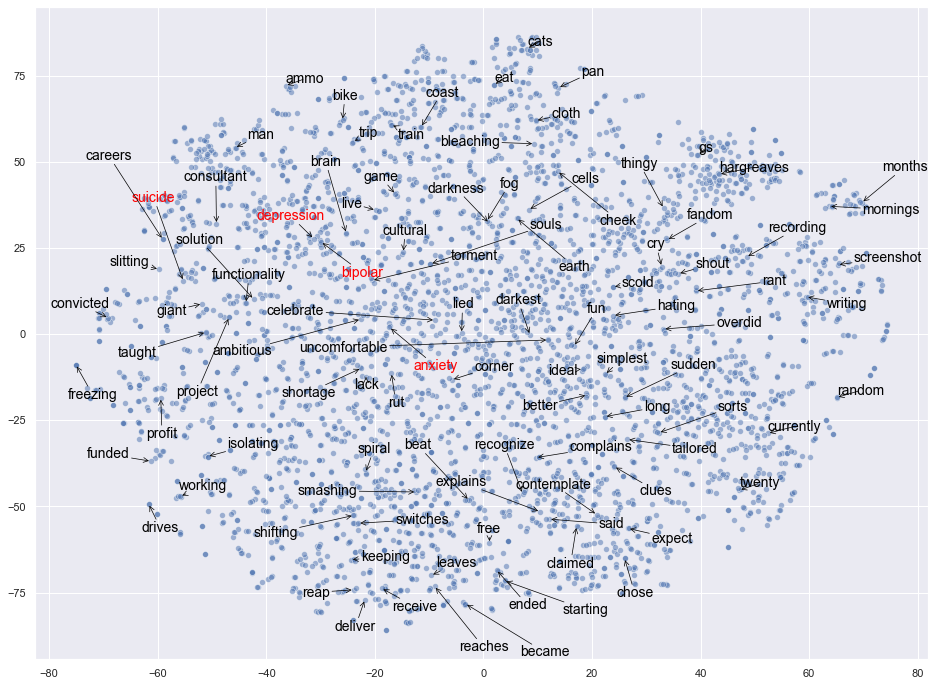

In [169]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (16, 12))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
texts_extra = []

words_to_plot = list(np.arange(0, len(df_word_wv)-4, 42))
words_to_plot_extra = [4004, 4005, 4006, 4007]

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_word_wv.index[word], fontsize = 14, color = 'black'))

for word in words_to_plot_extra:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_word_wv.index[word], fontsize = 14, color = 'red'))

adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,3),
            arrowprops = dict(arrowstyle = "->", color = 'black', lw = 0.7))

plt.show()

# PCA

In [29]:
pca = PCA(n_components=X_train_word_average.shape[1]-1, random_state=1)

X_train_pca = pca.fit_transform(X_train_word_average)

print(pca.explained_variance_ratio_.sum())

0.9998455761464332


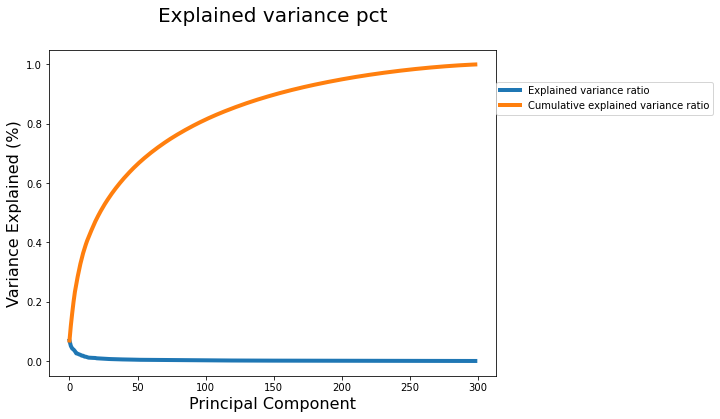

In [30]:
#Scree plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, lw=4, label='Explained variance ratio')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=4,
         label='Cumulative explained variance ratio')
plt.legend(loc=(1, 0.8))
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()

In [ ]:
pca_var_ratios = pca.explained_variance_ratio_

In [ ]:
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1

        if total_variance >= goal_var:
            break

    return n_components

In [33]:
select_n_components(pca_var_ratios, 0.99) 

268

In [ ]:
pca = PCA(n_components=select_n_components(pca_var_ratios, 0.99) , random_state=1)

X_train_word_average_pca = pca.fit_transform(X_train_word_average)
X_test_word_average_pca = pca.transform(X_test_word_average)

In [ ]:
X_train_w2v = np.concatenate([X_train.loc[:, ~X_train.columns.isin(['text'])], X_train_word_average_pca], axis=1)
X_test_w2v = np.concatenate([X_test.loc[:, ~X_train.columns.isin(['text'])], X_test_word_average_pca], axis=1)

# Standard Scaler

In [ ]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train_w2v) 
X_test_std = scaler.transform(X_test_w2v) 

# Grid Search

In [ ]:
def docm(y_true, y_pred, labels=None):
    '''Creates Document Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    if gs.classes_ is not None:
        cols = ['p_' + c for c in gs.classes_]
        df = pd.DataFrame(cm, index=gs.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=gs.classes_)
    return df

In [ ]:
'''Models and their grid-search parameters.'''
########################################################################
LR = LogisticRegression(multi_class = 'ovr', 
                        random_state = 1,
                        n_jobs=16
                       )
LR_params = {'C': np.logspace(-5, 5, 5),
             'solver': ['lbfgs', 'saga'],
             'max_iter': [500, 1000],
             'penalty': ['l1', 'l2']
            }

########################################################################

SVM_SGD = SGDClassifier(penalty='l2',
                        random_state=1,
                        learning_rate='optimal',
                        tol=None,
                        n_jobs=16
                       )
SVM_SGD_params = {'loss': ['hinge', 'squared_hinge'],
                  'alpha': np.linspace(1e-3, 0.5, 5),
                  'max_iter': [500, 1000],
                  'penalty': ['l1', 'l2', 'elasticnet']
                 }

########################################################################

KNC = KNeighborsClassifier(n_jobs=16
                          )
KNC_params = {'algorithm': ['auto'],
              'n_neighbors': [2, 10, 20],
              'p': [1, 2],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
             }

########################################################################

RFC = RandomForestClassifier(random_state=1,
                             n_estimators=100,
                             n_jobs=16
                            )
RFC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

ETC = ExtraTreesClassifier(random_state=1,
                           n_estimators=100,
                           n_jobs=16
                          )
ETC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

DTC = DecisionTreeClassifier(random_state=1
                            )
DTC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

In [ ]:
'''Grid Search'''

models = {'LogisticRegression': LR, 
          'SGDClassifier': SVM_SGD, 
          'KNeighborsClassifier': KNC,
          'DecisionTreeClassifier': DTC, 
          'RandomForestClassifier': RFC, 
          'ExtraTreeClassifier': ETC
         }

params = {'LogisticRegression': LR_params, 
          'SGDClassifier': SVM_SGD_params, 
          'KNeighborsClassifier': KNC_params,
          'DecisionTreeClassifier': DTC_params, 
          'RandomForestClassifier': RFC_params, 
          'ExtraTreeClassifier': ETC_params
         }

score_list = []
for name, model in models.items():
    accuracy = 0
    gs = GridSearchCV(estimator = model, 
                      param_grid = params[name], 
                      cv=5, 
                      verbose=1,
                      n_jobs=16
                     )
    
    gs.fit(X_train_std, y_train)
    
    best_est = gs.best_estimator_
    best_score = gs.best_score_ 
    best_params = gs.best_params_
    
    train_score = gs.score(X_train_std, y_train)
    test_score = gs.score(X_test_std, y_test)
    
    test_predictions = gs.predict(X_test_std)
    
    gs_results = pd.DataFrame(gs.cv_results_)
    score_list.append([name, train_score, test_score, best_score]) # Append main results of best estimator.
    
    joblib.dump(gs, f'{name}' + '_model.jlib') # Save model.
    gs_results.to_csv(f'{name}' + '_results', encoding='utf-8', index=False) # Export results to csv.
         
    # Print reports.
    print(name)
    print()
    print(best_score)
    print()
    print(classification_report(y_test, test_predictions, target_names=gs.classes_))
    print()
    print(docm(y_test, test_predictions))
    print()
    print('-'*80)

In [ ]:
df_scores = pd.DataFrame(score_list, columns=['model', 'train_score', 'test_score', 'best_score']) # Dataframe of main scores.
df_scores

df_scores.to_csv('/Users/francesco/df_scores', encoding='utf-8', index=False)

# Neural Network

In [ ]:
d = dict(zip(df.subreddit.unique(), range(0,4)))
d

In [ ]:
y_train = y_train.map(d, na_action='ignore')
y_test = y_test.map(d, na_action='ignore')

In [ ]:
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
np.random.seed(1337)

In [ ]:
keras.backend.backend()

In [ ]:
model = keras.Sequential()
alpha = 0.001

model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train_std.shape[1], ), kernel_regularizer=keras.regularizers.l2(alpha))) 
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
model.add(keras.layers.Dense(4, activation='softmax', kernel_regularizer=keras.regularizers.l2(alpha)))

optimizer = keras.optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 100

history = model.fit(
  X_train_std, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1, callbacks=[early_stop], batch_size=256)

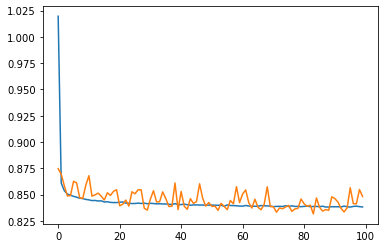

In [238]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
predicitions = model.predict(X_test_std)

In [ ]:
model.metrics_names

In [ ]:
model.evaluate(X_test_std, y_test, verbose=2)

In [ ]:
accuracy_score(y_test, predicitions.argmax(axis=1))

# Visualise Results

In [ ]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if model.classes_ is not None:
        cols = ['p_' + c for c in model.classes_]
        df = pd.DataFrame(cm, index=model.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=model.classes_)
    return df

In [ ]:
inv_d = {v: k for k, v in d.items()}
inv_d

In [ ]:
y_test = y_test.map(inv_d, na_action='ignore')
y_test

In [ ]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if d.keys() is not None:
        cols = [c for c in d.keys()]
        df = pd.DataFrame(cm, index=d.keys(), columns=cols)
    else:
        cols = [str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=d.keys())
    return df

In [ ]:
wv.most_similar(['depression'])

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools
    plt.figure(figsize=(13, 13))
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('BuGn')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=38, color='orange')
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=18)
    plt.tight_layout()
    plt.savefig("/cmat_.png", transparent=False, dpi=300)
    
    plt.show()

<Figure size 936x936 with 0 Axes>

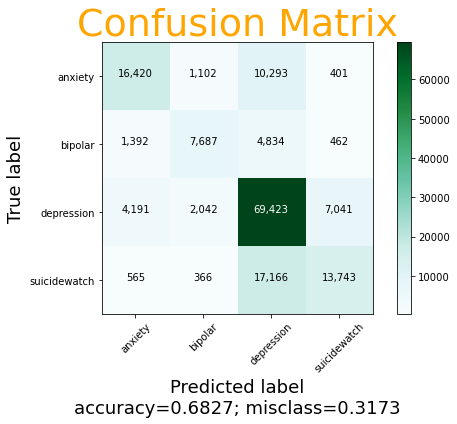

In [472]:
plot_confusion_matrix(cm           = np.array([[16420,  1102,   10293, 401],
                                              [1392,  7687,  4834, 462],
                                              [4191,  2042, 69423, 7041],
                                              [565, 366, 17166, 13743]]), 
                      normalize    = False,
                      target_names = ['anxiety', 'bipolar', 'depression', 'suicidewatch'],
                      title        = "Confusion Matrix NN")

In [151]:
print(classification_report(y_test, predicitions.argmax(axis=1), target_names=d.keys()))
print()
print(docm(y_test, predicitions.argmax(axis=1)))

              precision    recall  f1-score   support

     Anxiety       0.73      0.58      0.65     28216
     bipolar       0.69      0.53      0.60     14375
  depression       0.68      0.84      0.75     82697
SuicideWatch       0.63      0.43      0.51     31840

    accuracy                           0.68    157128
   macro avg       0.68      0.60      0.63    157128
weighted avg       0.68      0.68      0.67    157128


              Anxiety  bipolar  depression  SuicideWatch
Anxiety         16420     1102       10293           401
bipolar          1392     7687        4834           462
depression       4191     2042       69423          7041
SuicideWatch      565      366       17166         13743


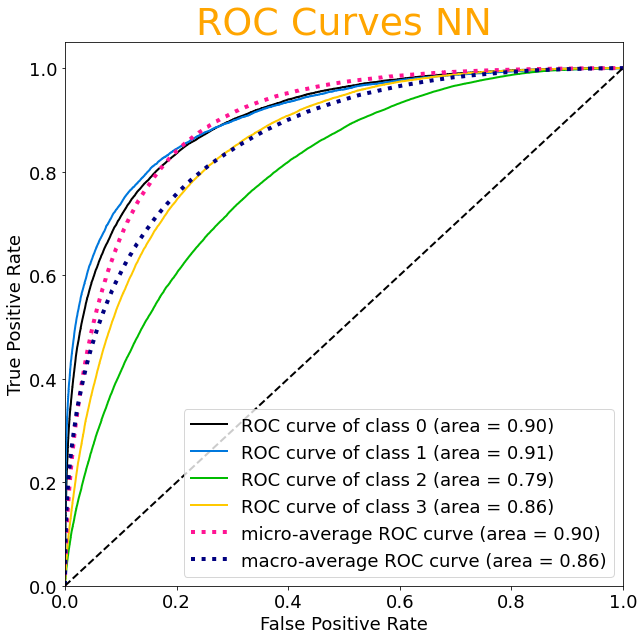

In [195]:
y_true = y_test
y_probas = predicitions
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10, 10), text_fontsize=18)
plt.title('ROC Curves NN', fontsize=38, color='orange')

plt.savefig("/ROC.png", transparent=True, dpi=300)
plt.show()